<a href="https://colab.research.google.com/github/jundeyo/minwondata/blob/master/%EB%B9%85%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_%EB%B0%8F_%EC%9D%B4%EB%A1%A0_%EC%B5%9C%EC%A2%85_%EB%B0%9C%ED%91%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 민원데이터 크롤링 및 데이터 분석

**라이브러리 로드**

In [4]:
# 라이브러리 로드
# requests는 작은 웹브라우저로 웹사이트 내용을 가져온다.
import requests
# BeautifulSoup 을 통해 읽어 온 웹페이지를 파싱한다.
from bs4 import BeautifulSoup as bs
# 크롤링 후 결과를 데이터프레임 형태로 보기 위해 불러온다.
import pandas as pd
# 크롤링 데이터를 읽는다.
import pandas_datareader as pdr
import re
import csv

# 새로운 값을 읽기 위한 플래그(CSV에 TRUE를 만나면 저장을 멈춘다.)
global breakfinal
breakfinal = False

**CSV에서 값을 읽어와 최종 데이터를 찾음.<p>**
번호 : 최종데이터값을 찾음.<p>
최신데이터를 읽기 위함.

In [13]:
import csv
# 크롤링한 데이터를 저장한 내용 중 가장 최종의 값을 반환.
def lastSequence():
  csvRead = pd.read_csv('/content/drive/My Drive/base/minwon.csv')
  csvRead = csvRead.loc[:,['번호','민원내용','민원일']]
  csvDelRow = csvRead[csvRead['번호'] == '번호'].index
  csvRead = csvRead.drop(csvDelRow)
  csvRead1 = csvRead['번호'].idxmax
  r = 0
  for k in csvRead['번호']:
    if (r < int(k)):
        r = int(k)
  print(r)
  return r


**민원데이터 크롤링 및 CSV 저장<p>**
민원데이터 : https://www.epeople.go.kr/nep/pttn/gnrlPttn/ciaPttnSmlrCaseList.npaid<p>
CSV : minwon.csv<p>

In [6]:
# 민원데이터 크롤링
def miinwon_Crawling(url, startNo, lastSeq):
  global breakfinal
  print(startNo)
  # 크롤링 할 사이트
  base_url = url
  #print(startNo)
  arr = []
  if (startNo == 1 and lastSeq == 0):
    arr.append(['번호', '민원내용', '카테고리', '민원일'])
  
  #for k in range(1,2,1):
  # 민원내용에서 페이징을 하여 조회
  params = {'pageIndex': startNo}
  response = requests.get( base_url,  params)
  soup = bs(response.text, 'html.parser')
  soup1 = soup.tbody
  #td영역을 조회함.
  tag = soup1.find_all("td")
  i = 0

  for td in tag:
    text = td.get_text()
    #print(i, text)
    # 첫번째 만나는 TD는 번호
    if (i == 0):
      sNo = text
      
      # CSV에 있는 최종 번호와 파싱한 번호를 비교하여 새로운 번호가 없으면 break한다.
      if (int(sNo) <= int(lastSeq)):
        breakfinal = True
        #print('breakfinal',sNo,lastSeq,breakfinal)
        break
    # 두번째 만나는 TD는 민원내용
    if (i == 1):
      sMinWon = text
    
    # 세번째 만나는 TD는 카테고리
    if (i == 2):
      sCata = text
    
    # 네번째 만나는 TD는 민원일
    if (i == 3):
      sDate = text
    
    # 네번째 만나면 arr변수에 어팬드함.
    if (i > 2):
      i = 0
      arr.append([sNo, sMinWon, sCata, sDate])
      sNo = ''
      sMinWon = ''
      sDate = ''
      sCata = ''
    else:
      i = i + 1
  return arr

# CSV에 새로저장
def toCSV(minwon_list):
    file = open('/content/drive/My Drive/base/minwon.csv', 'w', encoding='utf-8', newline='')
    csvfile = csv.writer(file)
    for row in minwon_list :
        csvfile.writerow(row)
    file.close()

# CSV에 추가저장
def toCSVUpdate(minwon_list):
    with open('/content/drive/My Drive/base/minwon.csv', 'a+', encoding='utf-8', newline='') as write_obj:
        csv_writer = csv.writer(write_obj)
        for row in minwon_list :
          csv_writer.writerow(row)

# 최대입력된 seq를 가져와 리턴함.
lastSeq = lastSequence()

# 크롤링 할 사이트
base_url = "https://www.epeople.go.kr/nep/pttn/gnrlPttn/ciaPttnSmlrCaseList.npaid"
params = {'pageIndex': '1'}
response = requests.get( base_url,  params)
soup = bs(response.text, 'html.parser')
soup1 = soup.tbody

#페이징 총 건수를 찾아옴.
totcnt = soup.findAll('span', class_='total')
totfinal = 0
for name in totcnt:
    tot = name.get_text()
    totfinal = int(tot[tot.find('/') + 1 : len(tot) - 1])

#페이징 총 건수만큼 크롤링을 시도함.
for k in range(1,totfinal + 1,1):
  print('iiii ' , breakfinal)
  # 새로운 데이터가 없으면 break
  if(breakfinal == True):
    break
    
  csvData = []
  # 크롤링을 시작함.
  csvData = miinwon_Crawling(base_url,k, lastSeq)
  
  # 데이터가 처음이면 CSV를 생성.
  if (k == 1 and lastSeq == 0):
    toCSV(csvData)
  # 처음이 아니면 CSV를 업데이트 저장함.
  else:
    toCSVUpdate(csvData)

# 잘 저장 되었는지 CSV파일을 읽어봄.
csvRead = pd.read_csv('/content/drive/My Drive/base/minwon.csv')
csvRead

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


iiii  False
1
iiii  True


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,번호,민원내용,카테고리,민원일
0,196411,관리가 안되어 방치되어 있고 조경수도 관리되지 않는 소하천 부지(시유지)에 대해서 ...,NaN,2020-06-14
1,196410,특정 토지에 대하여 시청에서 매입을 할수 있는지 궁금합니다.,NaN,2020-06-14
2,196409,충주시청 주차장 통행방향 관련하여 개선사항 요구합니다.,NaN,2020-06-14
3,196408,불법건축물이기도 한 빈집에 대해 제거시 시청에서 지원금이 나오나요?,NaN,2020-06-14
4,196407,망자가 된 아들의 자동차세금 고지및 납부를 부모에게 부담하라는 것인지 이해가 안됩니다.,NaN,2020-06-14
...,...,...,...,...
214546,202386,하남 감일지구 지하철 개통 원안 유지,NaN,2020-06-16
214547,202385,감일지구 3호선,NaN,2020-06-16
214548,202384,감일지구 3호선,NaN,2020-06-16
214549,202383,하남 감일지구 지하철 개통 원안 유지,NaN,2020-06-16


# **colab에 konlpy가 설치되어 있지 않아 설치함.**

In [6]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 8.0MB/s 
     |████████████████████████████████| 3.6MB 48.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


# get_tags : 문장에서 단어를 분리하여 명사와 갯수를 리턴<p>
# get_nouns_tags : 문장에서 명사만 최대 50개까지 분리함.<p>
# get_phrases_tags : 문장에서 구문을 최대 50개까지 분리함 <p>
# get_text : 배열에서 단어를 꺼내어 텍스트형식으로 , 구분으로 묶음. 굵은 텍스트 

In [7]:
import konlpy # 형태소 분리
from konlpy.tag import Twitter
from collections import Counter
import nltk

#okt = Twitter()

# 문장에서 단어를 분리하여 명사와 갯수를 나눔.
def get_tags(text, ntags=50):
    spliter = Twitter()
    nouns = spliter.nouns(text)
    count = Counter(nouns)
    return_list = []
    for n, c in count.most_common(ntags):
        temp = {'tag': n, 'count': c}
        return_list.append(temp)
    return return_list

# 문장에서 명사만 최대 50개까지 분리함.
def get_nouns_tags(text, ntags=50):
    spliter = Twitter()
    nouns = spliter.nouns(text)
    count = Counter(nouns)
    return_list = ''
    for n, c in count.most_common(ntags):
        return_list = return_list + n + ','
    return return_list

# 문장에서 구문을 최대 50개까지 분리함.
def get_phrases_tags(text, ntags=50):
    spliter = Twitter()
    phrases = spliter.phrases(text)
    count = Counter(phrases)
    return_list = ''
    for n, c in count.most_common(ntags):
        return_list = return_list + n + ','
    return return_list

# 배열에서 단어를 꺼내어 ,로 묶음.
def get_text(text):
  sText = ''
  for k in text:
    sText = sText + k + ','
  return sText

# **konlpy를 통하여 데이터의 형태소를 분석하고 명사 및 구문을 저장한다.<p>**
저장한 데이터는 minwon_result.csv, minwon_result.pkl에 넣는다.<p>
to_pickle을 사용하면 dataframe 형식으로 그대로 저장한다.<p>

In [ ]:
import konlpy # 형태소 분리
from konlpy.tag import Twitter
from collections import Counter
import nltk


# CSV를 읽어서 번호라는 데이터가 있는 잘 못 된 데이터의 행을 삭제함.
# 데이터프레임
csvRead = pd.read_csv('/content/drive/My Drive/base/minwon.csv')
csvRead = csvRead.loc[:,['번호','민원내용','민원일']]
csvDelRow = csvRead[csvRead['번호'] == '번호'].index
csvRead = csvRead.drop(csvDelRow)

# 데이터 프레임을 읽어서 명사와 구절, 진행상태의 열을 추가함.
# 크롤링한 데이터에는 상태가 없으나 분석 목적으로 가상으로 상태를 만듦.
for i, row in csvRead.iterrows() :
    csvRead.at[i,'명사추출'] = get_nouns_tags(csvRead.at[i,'민원내용'])
    csvRead.at[i,'구절추출'] = get_phrases_tags(csvRead.at[i,'민원내용'])
    if (csvRead.at[i,'민원일'] == '2020-06-15'):
        csvRead.at[i,'민원상태'] = '진행'
    else:
        csvRead.at[i,'민원상태'] = '종료'

# 새로 만든 데이터프레임을 minwon_rusult.csv, minwon_rusult.pkl에 저장함.
csvRead.to_csv('/content/drive/My Drive/base/minwon_rusult.csv') #새로 추가된 열을 포함하여 CSV를 저장함.
csvRead.to_pickle('/content/drive/My Drive/base/minwon_rusult.pkl') #데이터프레임의 구조를 그대로 저장함.

# 데이터프레이을 출력해봄.
csvRead

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


,번호,민원내용,민원일,명사추출,구절추출,민원상태
0,196411,관리가 안되어 방치되어 있고 조경수도 관리되지 않는 소하천 부지(시유지)에 대해서 ...,2020-06-14,"관리,방치,조경수,소하천,부지,시유,대해,인근,주민,사용,수,허용,","관리,방치,조경수,소하천,소하천 부지,시유,대해,인근,인근 주민,사용,사용할 수,허...",종료
1,196410,특정 토지에 대하여 시청에서 매입을 할수 있는지 궁금합니다.,2020-06-14,"특정,토지,대하,시청,매입,","특정,특정 토지,대하,시청,매입,토지,",종료
2,196409,충주시청 주차장 통행방향 관련하여 개선사항 요구합니다.,2020-06-14,"충주,시청,주차장,통행,방향,관련,개선,사항,요구,","충주시청,충주시청 주차장,충주시청 주차장 통행방향,충주시청 주차장 통행방향 관련,개...",종료
3,196408,불법건축물이기도 한 빈집에 대해 제거시 시청에서 지원금이 나오나요?,2020-06-14,"불법,건축물,빈집,대해,제거,시,시청,원금,","불법건축물,빈집,대해,대해 제거시,대해 제거시 시청,지원금,불법,건축물,제거,시청,",종료
4,196407,망자가 된 아들의 자동차세금 고지및 납부를 부모에게 부담하라는 것인지 이해가 안됩니다.,2020-06-14,"망,아들,자동차,세금,고지,및,납부,부모,부담,것,이해,","망자,아들,아들의 자동차세금,아들의 자동차세금 고지및,아들의 자동차세금 고지및 납부...",종료
...,...,...,...,...,...,...
214546,202386,하남 감일지구 지하철 개통 원안 유지,2020-06-16,"하남,감일,지구,지하철,개통,원안,유지,","하남,하남 감일지구,하남 감일지구 지하철,하남 감일지구 지하철 개통,하남 감일지구 ...",종료
214547,202385,감일지구 3호선,2020-06-16,"감일,지구,호선,","감일지구,감일지구 3호선,감일,지구,호선,",종료
214548,202384,감일지구 3호선,2020-06-16,"감일,지구,호선,","감일지구,감일지구 3호선,감일,지구,호선,",종료
214549,202383,하남 감일지구 지하철 개통 원안 유지,2020-06-16,"하남,감일,지구,지하철,개통,원안,유지,","하남,하남 감일지구,하남 감일지구 지하철,하남 감일지구 지하철 개통,하남 감일지구 ...",종료


# **pickle을 다시 읽어와 정확히 저장되었는지 확인함.**

In [8]:
csvRead = pd.read_pickle('/content/drive/My Drive/base/minwon_rusult.pkl')
csvRead

,번호,민원내용,민원일,명사추출,구절추출,민원상태
0,196411,관리가 안되어 방치되어 있고 조경수도 관리되지 않는 소하천 부지(시유지)에 대해서 ...,2020-06-14,"관리,방치,조경수,소하천,부지,시유,대해,인근,주민,사용,수,허용,","관리,방치,조경수,소하천,소하천 부지,시유,대해,인근,인근 주민,사용,사용할 수,허...",종료
1,196410,특정 토지에 대하여 시청에서 매입을 할수 있는지 궁금합니다.,2020-06-14,"특정,토지,대하,시청,매입,","특정,특정 토지,대하,시청,매입,토지,",종료
2,196409,충주시청 주차장 통행방향 관련하여 개선사항 요구합니다.,2020-06-14,"충주,시청,주차장,통행,방향,관련,개선,사항,요구,","충주시청,충주시청 주차장,충주시청 주차장 통행방향,충주시청 주차장 통행방향 관련,개...",종료
3,196408,불법건축물이기도 한 빈집에 대해 제거시 시청에서 지원금이 나오나요?,2020-06-14,"불법,건축물,빈집,대해,제거,시,시청,원금,","불법건축물,빈집,대해,대해 제거시,대해 제거시 시청,지원금,불법,건축물,제거,시청,",종료
4,196407,망자가 된 아들의 자동차세금 고지및 납부를 부모에게 부담하라는 것인지 이해가 안됩니다.,2020-06-14,"망,아들,자동차,세금,고지,및,납부,부모,부담,것,이해,","망자,아들,아들의 자동차세금,아들의 자동차세금 고지및,아들의 자동차세금 고지및 납부...",종료
...,...,...,...,...,...,...
214546,202386,하남 감일지구 지하철 개통 원안 유지,2020-06-16,"하남,감일,지구,지하철,개통,원안,유지,","하남,하남 감일지구,하남 감일지구 지하철,하남 감일지구 지하철 개통,하남 감일지구 ...",종료
214547,202385,감일지구 3호선,2020-06-16,"감일,지구,호선,","감일지구,감일지구 3호선,감일,지구,호선,",종료
214548,202384,감일지구 3호선,2020-06-16,"감일,지구,호선,","감일지구,감일지구 3호선,감일,지구,호선,",종료
214549,202383,하남 감일지구 지하철 개통 원안 유지,2020-06-16,"하남,감일,지구,지하철,개통,원안,유지,","하남,하남 감일지구,하남 감일지구 지하철,하남 감일지구 지하철 개통,하남 감일지구 ...",종료


# **딕셔너리를 파라미터로 넘기면 wordcloud로 표현하는 펑션**

In [9]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import datetime
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
import matplotlib
from IPython.display import set_matplotlib_formats

# 워드클라우드
def wrodcloudShow(text):
  matplotlib.rc('font',family = 'Malgun Gothic')

  set_matplotlib_formats('retina')

  matplotlib.rc('axes',unicode_minus = False)

  wordcloud = WordCloud(font_path = '/content/drive/My Drive/base/malgun.ttf', background_color='white',colormap = "Accent_r",width=1500, height=1000).generate_from_frequencies(text)

  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

# **최근 3일간 가장 많이 나온 단어를 찾는다. - 20개**

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


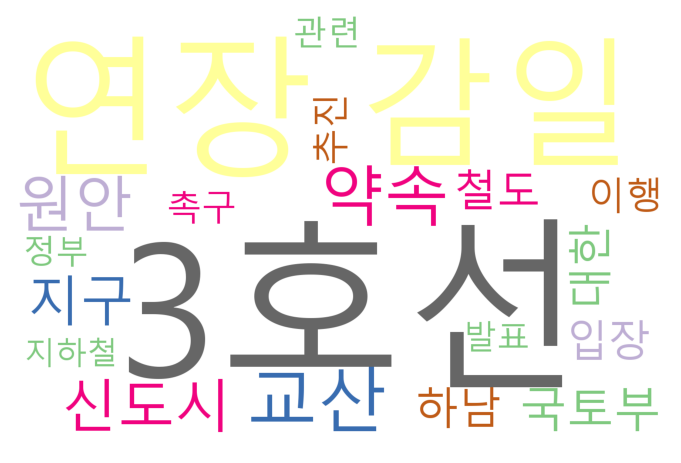

,3호선,연장,감일,교산,약속,원안,신도시,지구,국토부,대한,하남,철도,입장,이행,추진,촉구,관련,발표,정부,지하철
건수,9441,5940,4988,4207,3468,2956,2666,2339,1821,1588,1565,1537,1530,1161,1080,985,912,898,881,801


In [10]:
import datetime
from sklearn.feature_extraction.text import CountVectorizer

# 텍스트에서 명사를 추출하여 갯수와 함께 딕셔너리를 리턴함.
def get_tags_text(arr):
  text = {}

  tags = get_tags(arr, 20)

  for tag in tags:
          noun = tag['tag']
          if (noun == '호선'):
            noun = '3호선'
          count = tag['count']
          text[noun] =  count

  return text

# 몇일전까지의 민원일자를 받아 그 안에서 명사를 추출하여 갯수를 딕셔너리로 리턴함.
def wordCount(count):
  # 오늘부터 몇일전
  days_ago = datetime.datetime.now() - datetime.timedelta(days=count)
  dateAgo = days_ago.strftime("%Y-%m-%d")

  # 데이터 프레임에서 해당 민원일자보다 큰 데이터 프레임을 가지고 옴.
  csvRead_result1 = csvRead[csvRead['민원일'] >= dateAgo]
  arr = ''
  for text in csvRead_result1['명사추출']:
    arr = arr + text + ' '

  text = {}
  # 명사와 갯수를 구함.
  text = get_tags_text(arr)

  return text

# 3일전의 민원내용 중 가장 많이 나오는 20개의 단어를 추출하여 워드클라우드를 생성함.
text = {}
text = wordCount(3)

# 데이터프레임의 컬럼을 건수라고 표현하고 저장함.
pdData1 = pd.DataFrame.from_dict(text,orient='index',columns=['건수'])

# 워드클라우드생성
wrodcloudShow(text)

# 세로의 형태를 가로로 표현함.
pdData1 = pdData1.transpose()
pdData1

# **최근 1일간 가장 많이 나온 단어를 워드클라우드로 보여준다.**

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


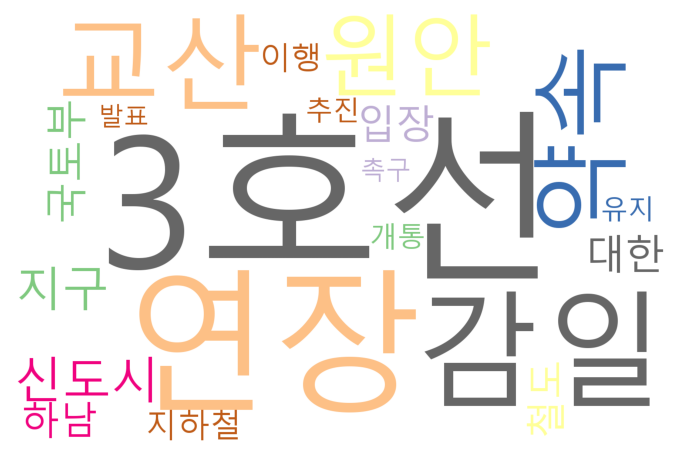

,3호선,연장,감일,교산,약속,원안,신도시,지구,국토부,대한,철도,입장,하남,지하철,이행,개통,추진,유지,촉구,발표
건수,4817,3287,2633,2271,1970,1827,1518,1414,1134,1049,1028,1027,969,658,623,492,467,465,408,403


In [11]:
# 1일전의 민원내용 중 가장 많이 나오는 20개의 단어를 추출하여 워드클라우드를 생성함.
text = {}
text = wordCount(1)

# 데이터프레임의 컬럼을 건수라고 표현하고 저장함.
pdData1 = pd.DataFrame.from_dict(text,orient='index',columns=['건수'])
# 워드클라우드생성
wrodcloudShow(text)
# 세로의 형태를 가로로 표현함.
pdData1 = pdData1.transpose()
pdData1



# **최근 1년간 가장 많이 나온 단어를 찾는다.**

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


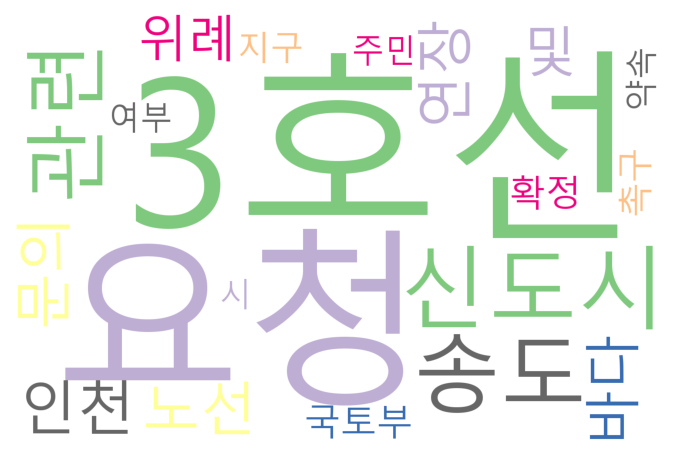

,3호선,요청,신도시,송도,관련,인천,노선,문의,연장,바다,및,위례,국토부,확정,촉구,지구,시,약속,여부,주민
건수,25441,22259,18348,17510,15493,14089,13393,12891,12651,12486,11813,9520,9408,9345,8652,7885,7395,7303,7299,7208


In [12]:
# 1년전의 민원내용 중 가장 많이 나오는 20개의 단어를 추출하여 워드클라우드를 생성함.
text = {}
text = wordCount(365)

# 데이터프레임의 컬럼을 건수라고 표현하고 저장함.
pdData1 = pd.DataFrame.from_dict(text,orient='index',columns=['건수'])
# 워드클라우드생성
wrodcloudShow(text)
# 세로의 형태를 가로로 표현함.
pdData1 = pdData1.transpose()
pdData1

# **가장데이터가 많이 나오는 3호선과 관련된 리스트를 찾는다.**


/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


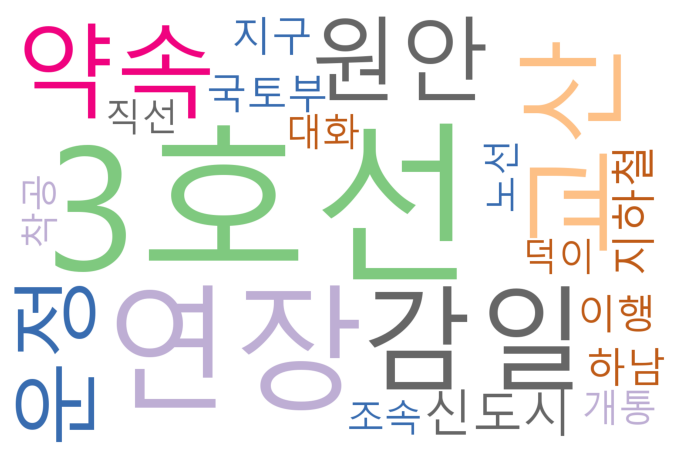

,3호선,연장,감일,교산,약속,원안,운정,신도시,지하철,국토부,지구,하남,이행,노선,착공,개통,덕이,직선,조속,대화
건수,15696,8836,6090,5883,5288,4283,3862,3480,2764,2293,2277,2252,2197,1941,1941,1941,1937,1937,1936,1935


In [14]:
# 데이터프레임에서 3호선이 포함된 민원내용을 찾음.
csvRead_3ho = csvRead['민원내용'].str.contains("3호선")
csvRead_3hosun = csvRead[csvRead_3ho]

arr = ''

for text in csvRead_3hosun['민원내용']:
    arr = arr + text + ' '

# 민원내용을 파싱하여 명사, 갯수를 리턴함.
text = {}
text = get_tags_text(arr)

# 데이터프레임의 컬럼을 건수라고 표현하고 저장함.
pdData1 = pd.DataFrame.from_dict(text,orient='index',columns=['건수'])
# 워드클라우드생성
wrodcloudShow(text)
# 세로의 형태를 가로로 표현함.
pdData1 = pdData1.transpose()
pdData1

# **최근 30일 중 데이터 값 중에 가장 많이 나오는 단어인 [3호선]을 불용어로 처리하여 가장 많이 나오는 단어를 찾는다.**

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


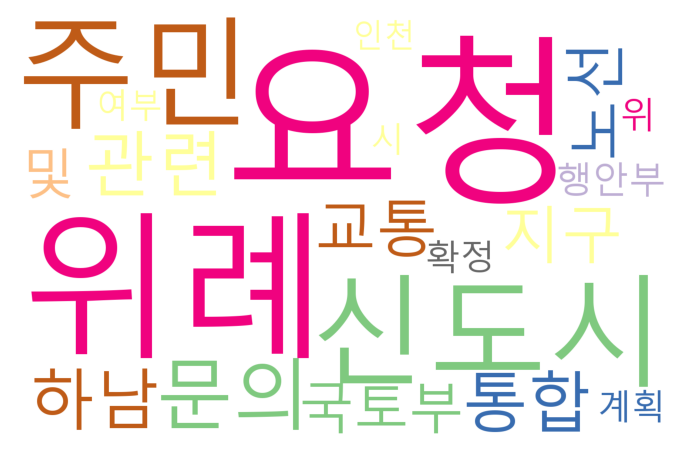

,번호,민원내용,민원일,명사추출,구절추출,민원상태
0,196411,관리가 안되어 방치되어 있고 조경수도 관리되지 않는 소하천 부지(시유지)에 대해서 ...,2020-06-14,"관리,방치,조경수,소하천,부지,시유,대해,인근,주민,사용,수,허용,","관리,방치,조경수,소하천,소하천 부지,시유,대해,인근,인근 주민,사용,사용할 수,허...",종료
1,196410,특정 토지에 대하여 시청에서 매입을 할수 있는지 궁금합니다.,2020-06-14,"특정,토지,대하,시청,매입,","특정,특정 토지,대하,시청,매입,토지,",종료
2,196409,충주시청 주차장 통행방향 관련하여 개선사항 요구합니다.,2020-06-14,"충주,시청,주차장,통행,방향,관련,개선,사항,요구,","충주시청,충주시청 주차장,충주시청 주차장 통행방향,충주시청 주차장 통행방향 관련,개...",종료
3,196408,불법건축물이기도 한 빈집에 대해 제거시 시청에서 지원금이 나오나요?,2020-06-14,"불법,건축물,빈집,대해,제거,시,시청,원금,","불법건축물,빈집,대해,대해 제거시,대해 제거시 시청,지원금,불법,건축물,제거,시청,",종료
4,196407,망자가 된 아들의 자동차세금 고지및 납부를 부모에게 부담하라는 것인지 이해가 안됩니다.,2020-06-14,"망,아들,자동차,세금,고지,및,납부,부모,부담,것,이해,","망자,아들,아들의 자동차세금,아들의 자동차세금 고지및,아들의 자동차세금 고지및 납부...",종료


In [15]:
# 30일전의 날짜를 찾는다.
days_ago = datetime.datetime.now() - datetime.timedelta(days=30)
dateAgo = days_ago.strftime("%Y-%m-%d")
# 민원일자가 최근 30일 데이터 프레임을 찾는다.
csvRead_result1 = csvRead[csvRead['민원일'] >= dateAgo]

# 3호선을 불용어로 처리하여 포함하지 않는 민원내용을 찾음.
csvRead_3ho = (csvRead_result1['민원내용'].str.contains("3호선") == False)
csvRead_3hosun = csvRead_result1[csvRead_3ho]

arr = ''

# 민원내용을 파싱하여 명사, 갯수를 리턴함.
for text in csvRead_3hosun['민원내용']:
    arr = arr + text + ' '

text = {}
text = get_tags_text(arr)

# 워드클라우드생성
wrodcloudShow(text)

# 데이터 프레임 중 5개만 나오게 함.
csvRead_3hosun.head(5)



# **진행중인 민원의 갯수와 종료된 민원의 갯수를 알려준다.**

In [16]:
# 민원이 종료되었는지 진행상태인지 그룹바이를 하여 카운팅함.
csvReadCount = csvRead.groupby(by=['민원상태'], as_index=False).count()
# 번호 컬럼을 총건수라는 컬럼으로 변경함.
csvReadCount = csvReadCount.rename({'번호':'총건수'},axis='columns')
csvReadCount[['민원상태','총건수']]

,민원상태,총건수
0,종료,208580
1,진행,5970


# **진행중인 민원 중 가장 많이 나온 단어를 알려준다.**

In [17]:
# 민원상태가 진행중인 데이터프레임을 가져옴.
csvRead_result1 = csvRead[csvRead['민원상태'] == '진행']

arr = ''

for text in csvRead_result1['민원내용']:
    arr = arr + text + ' '
# 명사와 갯수를 리턴함.
text = {}
text = get_tags_text(arr)

# 건수라고 컬럼을 변경한 후 저장함.
pdData1 = pd.DataFrame.from_dict(text,orient='index',columns=['건수'])
# 세로 형태를 가로로 변경하여 출력함.
pdData1 = pdData1.transpose()

pdData1

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


,3호선,연장,감일,교산,약속,신도시,원안,지구,국토부,추진,하남,촉구,관련,이행,대한,철도,입장,발표,정부,계획
건수,4710,2735,2356,1949,1499,1147,1129,881,687,614,611,574,558,541,534,509,503,495,491,274


# **진행중인 민원의 리스트를 보여준다.**

In [18]:
# 진행중인 민원상태의 데이터 프레임을 읽어옴.
csvRead_result1 = csvRead[csvRead['민원상태'] == '진행']
# 30개만 출력해봄.
csvRead_result1.head(30)

,번호,민원내용,민원일,명사추출,구절추출,민원상태
202562,202381,기흥역세권 내 중학교 추진연합회와 용인시장의 미팅을 요구합니다.,2020-06-15,"기흥역,권,내,중학교,추진,연합,회,용인시,미팅,요구,","기흥역세권,기흥역세권 내,기흥역세권 내 중학교,기흥역세권 내 중학교 추진연합회,기흥...",진행
202563,202380,호국안보행사 영화소품 체험전,2020-06-15,"호국,안보,행사,영화,소품,체험,전,","호국안보행사,호국안보행사 영화소품,호국안보행사 영화소품 체험전,호국,안보,행사,영화...",진행
202564,202379,국토교통부 주택기금과의 상담,2020-06-15,"국토교통부,주택,기금,상담,","국토교통부,국토교통부 주택기금,상담,주택,기금,",진행
202565,202378,건축허가 받은 분양관련 문의입니다.,2020-06-15,"건축,허가,분양,관련,문의,","건축허가,건축허가 받은 분양관련,건축허가 받은 분양관련 문의,건축,허가,분양,관련,문의,",진행
202566,202377,친절함에 감사,2020-06-15,"감사,","감사,",진행
202567,202376,비산배출시설 관리제도 상의 보일러 THC 측정 관련,2020-06-15,"비산,배출,시설,관리제,상의,보일러,측정,관련,","비산배출시설,비산배출시설 관리제,상의,상의 보일러,상의 보일러 THC,상의 보일러 ...",진행
202568,202375,"""공공발주사업에 대한 건축사의 업무범위 및 대가기준""에서 공사비요율방식에 설계자의 ...",2020-06-15,"업무,대가,발주,사업,대한,건축사,범위,및,기준,사비,율,방식,설계자,안전,관리,설...","공공발주사업,대한,대한 건축사,대한 건축사의 업무범위,대한 건축사의 업무범위 및,대...",진행
202569,202374,집시법위반자도 아이를 입양하는데 부적자인가요?,2020-06-15,"집시법,위반,자도,아이,입양,부적,","집시법위반자도,집시법위반자도 아이,입양,부적자,집시법,위반,자도,아이,",진행
202570,202373,해외파견근로자는 긴급재난지원금 지급을 왜 제외하는가?,2020-06-15,"해외,파견,근로자,긴급,재난,원금,지급,왜,제외,","해외파견근로자,긴급재난,원금,원금 지급,왜 제외,해외,파견,근로자,긴급,재난,지급,제외,",진행
202571,202372,"건설공사 중 안전관리비 계상항목 관련 문의입니다(일명, 스마트 안전관리비)",2020-06-15,"안전,관리,비,건설,공사,중,계,항목,관련,문의,일명,스마트,","건설공사,건설공사 중,건설공사 중 안전관리비,건설공사 중 안전관리비 계상항목,건설공...",진행


# **colab의 한글폰트 문제를 해결함.**

In [19]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum
import matplotlib.font_manager as fm
fontpath = '/content/drive/My Drive/base/malgun.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
fm._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


# **6월 일수별 민원의 건수를 보여준다.**

In [20]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 2020년 6월의 민원내용을 가져옴.
csvRead_3ho = csvRead['민원일'].str.contains("2020-06")
csvRead_3hosun = csvRead[csvRead_3ho]

csvRead_3hosun

# 2020년 6월의 일자별 민원을 카운팅함.
csvReadCount = csvRead_3hosun.groupby(by=['민원일'], as_index=False).count()
# 번호 컬럼을 민원건수라고 컬럼명을 변경함.
csvReadCount = csvReadCount.rename({'번호':'민원건수'},axis='columns')

csvReadCount = csvReadCount[['민원일','민원건수']]
# 민원일자를 인덱스화 시킴.
csvReadCount = csvReadCount.set_index("민원일")

csvReadCount1 = csvReadCount

# 세로를 가로로 표현함.
csvReadCount = csvReadCount.transpose()
csvReadCount



민원일,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16
민원건수,1218,2403,1035,1327,1028,251,83,1319,1804,1148,1951,5246,69,108,5970,6019


# **6월 일수별 민원의 건수를 차트로 보여준다.**

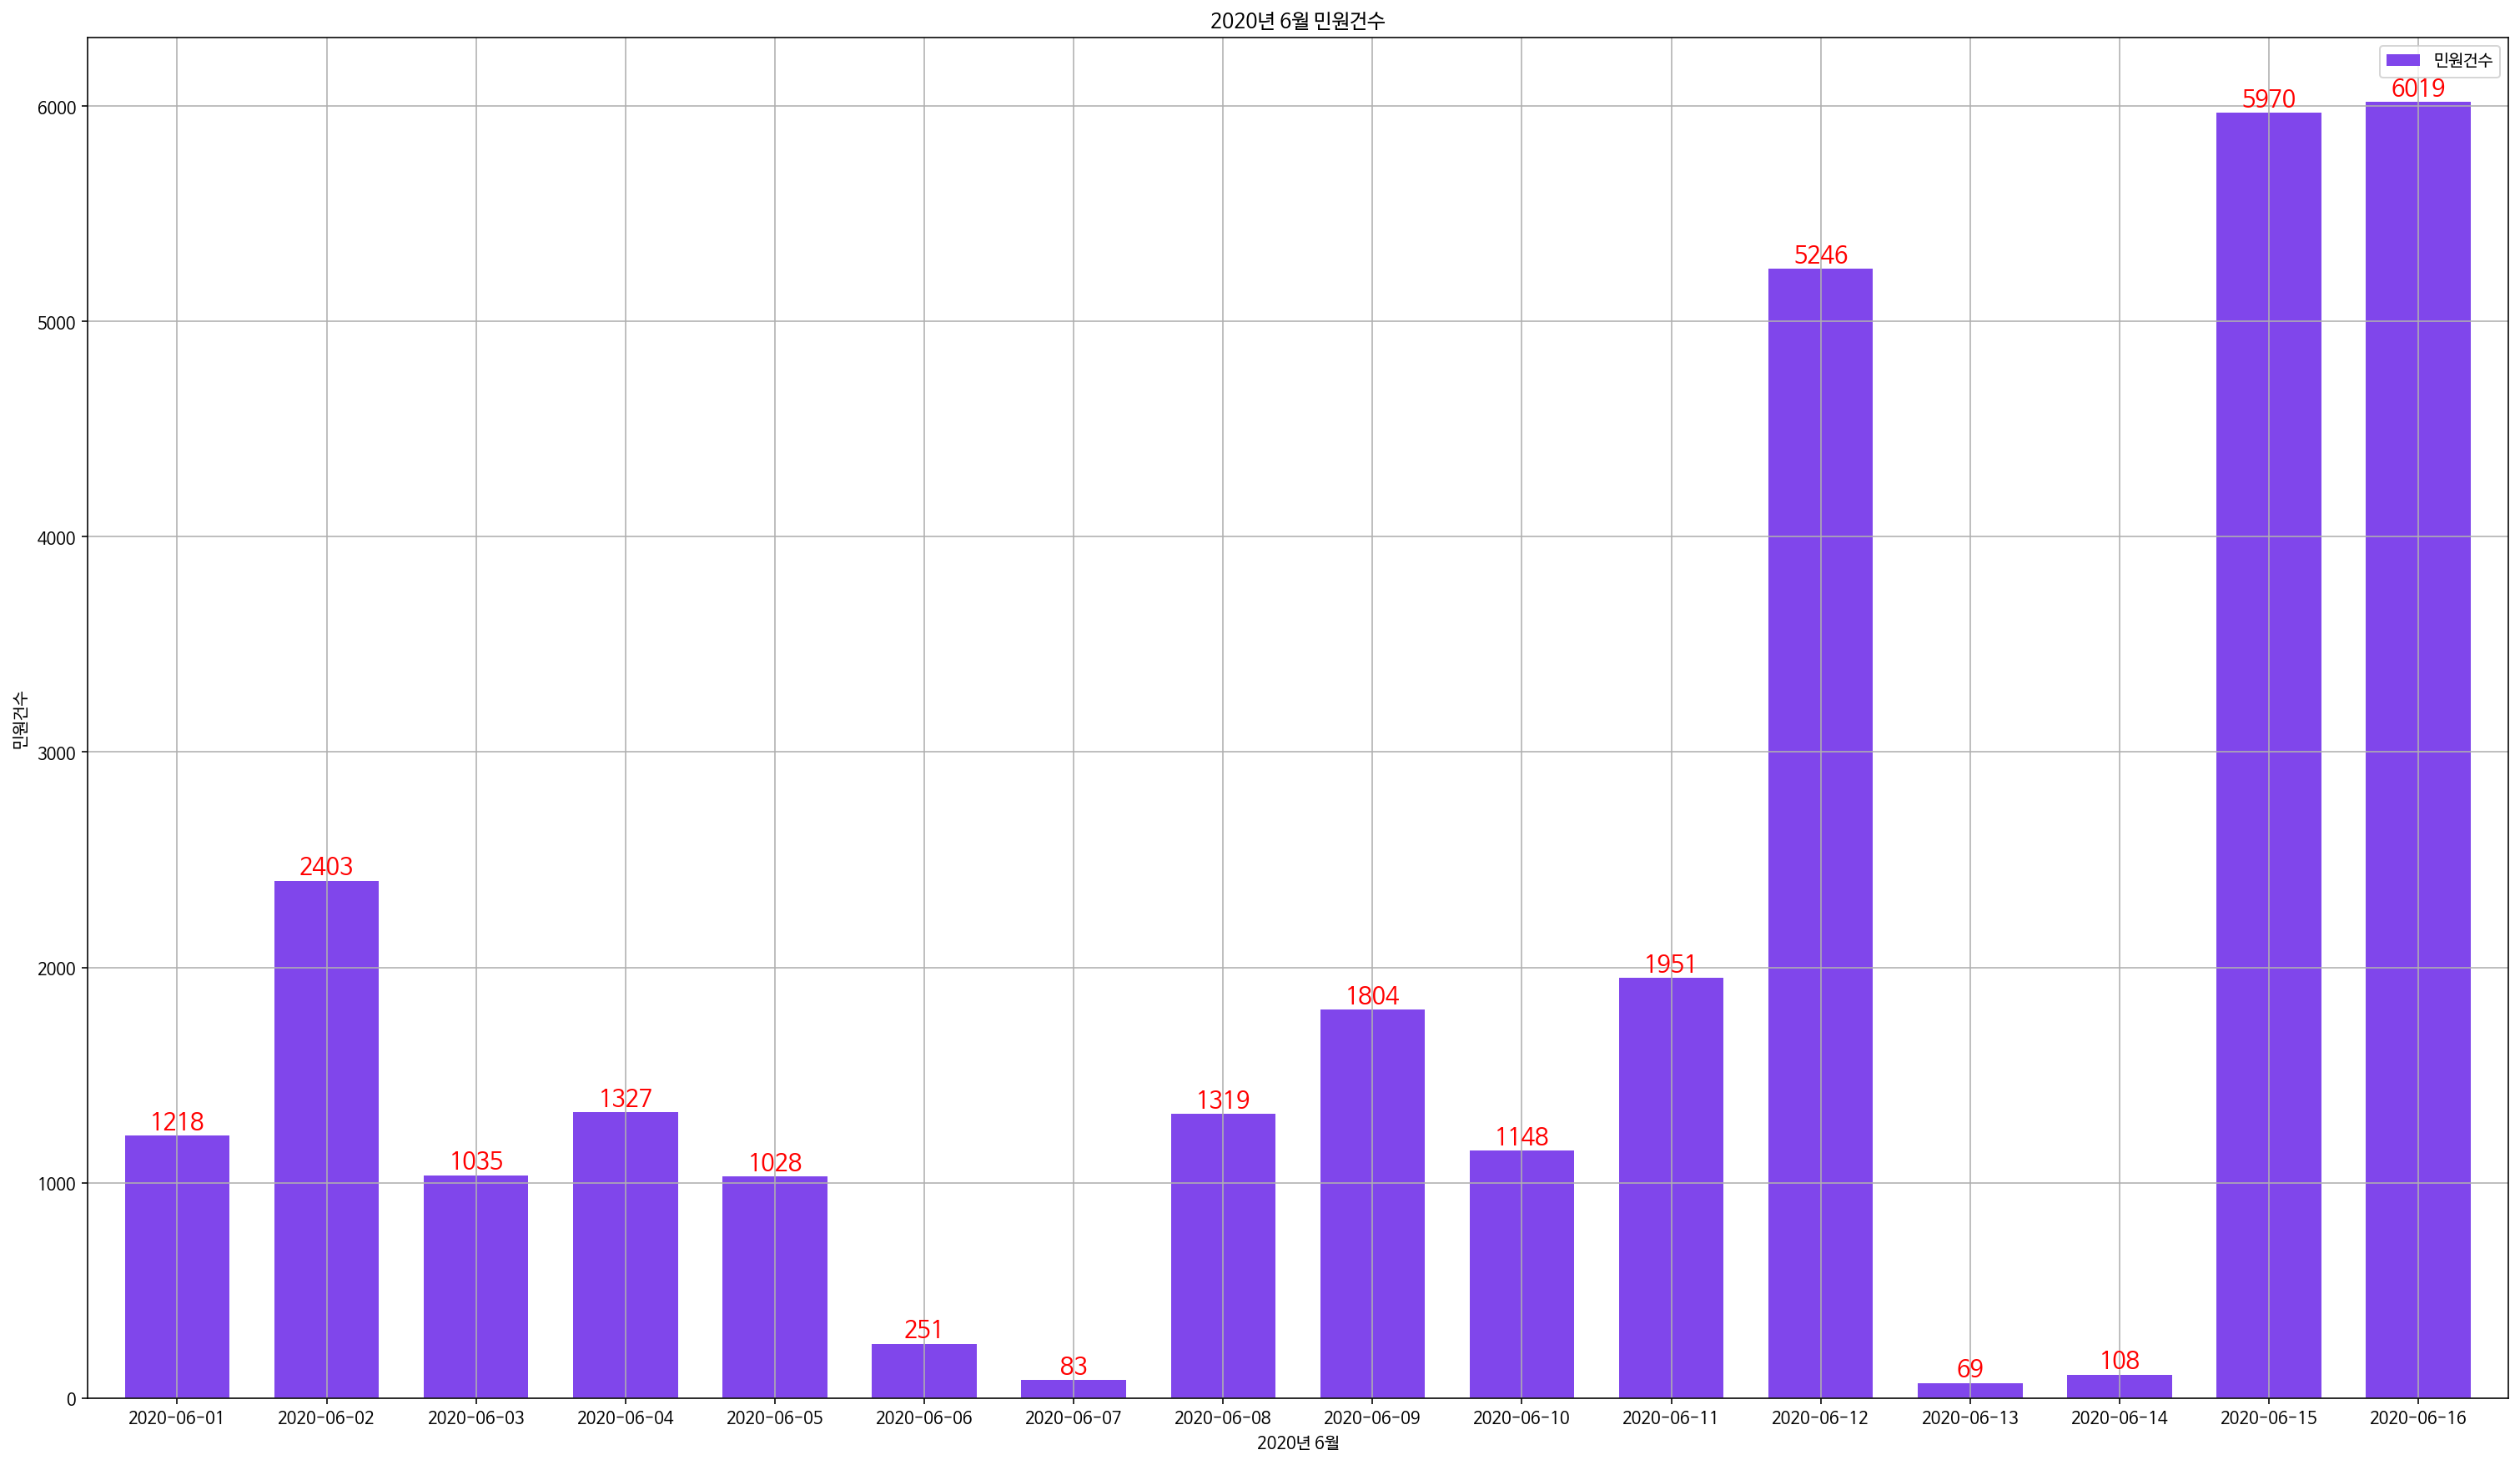

In [21]:
from matplotlib import pyplot
import matplotlib.pylab as plt

# 그래프의 크기를 정함.
plt.rcParams["figure.figsize"] = (26,15)
# 일자별 민원건수를 읽어 bar로 표현함.
csvReadCount1['민원건수'].plot.bar(color='#8046eb', rot=0, width=0.7)
pyplot.grid()
pyplot.legend()
# 제목 표현.
pyplot.title("2020년 6월 민원건수")
# x축
pyplot.xlabel("2020년 6월")
# y축
pyplot.ylabel("민원건수")   

# 그래프에 텍스트 표시하기
# 그래프에 표시되는 실 데이터는 y축 좌표를 의미하고, x축은 0부터 시작하는 좌표값을 갖는다.
for x, y in enumerate( list(csvReadCount1['민원건수']) ):
    txt = "%d" % y
    pyplot.text(x, y, txt, fontsize=14, color='#ff0000', 
                    horizontalalignment='center', verticalalignment='bottom')
    
pyplot.show()

# **word2vec을 통하여 단어간 유사도를 구함.**

In [22]:
 from gensim.models import word2vec
 result= []
 # 명사를 추출한다.
 for text in csvRead['명사추출']:
   text = text.replace(","," ")
   text = text.replace("호선","3호선")
   result.append(text)

#형태소들을 별도의 파일로 저장 합니다.
with open("/content/drive/My Drive/base/minwonModel.nlp",'w', encoding='utf-8') as fp:
     fp.write("\n".join(result))

 #Word2Vec 모델 만들기
 wData = word2vec.LineSentence("/content/drive/My Drive/base/minwonModel.nlp")
 wModel =word2vec.Word2Vec(wData, size=200, window=10, hs=1, min_count=2, sg=1)
 wModel.save("/content/drive/My Drive/base/minwonModel.model")


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [23]:
from gensim.models import Word2Vec

model = word2vec.Word2Vec.load("/content/drive/My Drive/base/minwonModel.model")

# 요금과 관련된 유사성을 갖는 단어 찾기
print(model.wv.most_similar(positive=["요금"]))

# 연장과 관련된 유사성을 갖는 단어 찾기
print(model.wv.most_similar(positive=["연장"]))

# 두 단어의 연관성 찾기
print ('두 단어의 연관성 : ', model.similarity('연장', '3호선'))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[('불만', 0.6591701507568359), ('회선', 0.6453239917755127), ('신용등급', 0.6325266361236572), ('멤버십', 0.6265684366226196), ('치비', 0.6231631636619568), ('기변', 0.6163449287414551), ('허무인', 0.614030659198761), ('미고', 0.5933283567428589), ('이동전화', 0.5880899429321289), ('약정', 0.5755412578582764)]
[('토부', 0.5566715002059937), ('존안', 0.5464834570884705), ('지선', 0.5363448858261108), ('봉오대로', 0.5295271277427673), ('태전역', 0.528511643409729), ('연장확정', 0.5265982151031494), ('오금', 0.5168002247810364), ('행해', 0.5164593458175659), ('청라지구', 0.5124021768569946), ('호산', 0.5110381841659546)]
두 단어의 연관성 :  0.5014537


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if sys.path[0] == '':
